In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import frame_whitening as fw
import frame_whitening.data as fwd

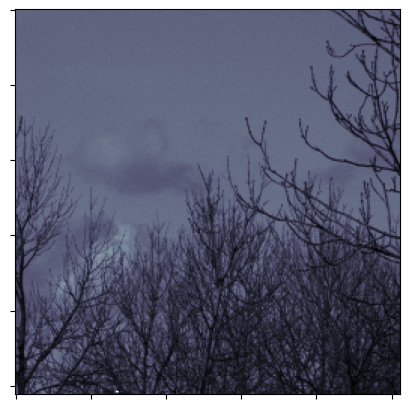

In [66]:
data_dir = "/mnt/home/tyerxa/ceph/datasets/datasets/vanhateren_imc"
files = sorted(os.listdir(data_dir))
seed = 696969
rng = np.random.default_rng(seed)

n_images = 10
images = fwd.load_images(n_images=n_images, crop_size=256, rng=rng)

images = [img / np.max(img) for img in images]

img = images[4]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(img, cmap="bone")
ax.set(xticklabels=[], yticklabels=[]);

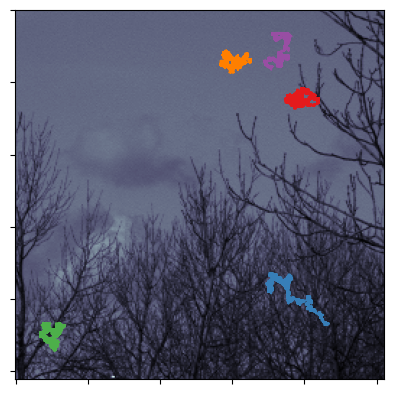

In [67]:
patch_h, patch_w = 16, 16
img_h, img_w = img.shape

sigma = .1
n_steps = 20_000

fig, ax = plt.subplots(1, 1)
im = ax.imshow(img, cmap="bone")
# plt.colorbar(im)
ax.set(xticklabels=[], yticklabels=[])

n_contexts = 5
cols = sns.color_palette("Set1", n_contexts)

all_contexts, walk_coords = fwd.get_contexts(img, patch_h, patch_w, n_contexts, sigma, n_steps, pad_factor=1, rng=rng)
for idx, walk_hw in enumerate(walk_coords):
    walk_h, walk_w = walk_hw[:, 0], walk_hw[:, 1]
    ax.plot(walk_h, walk_w, color=cols[idx])

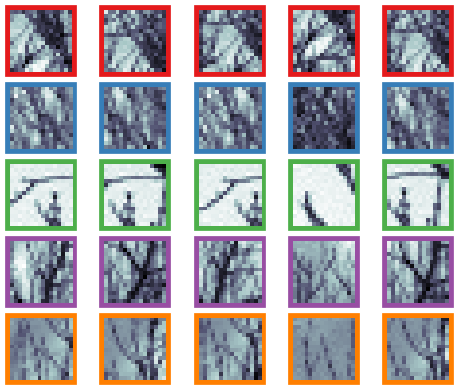

In [43]:
fwd.plot_context_samples(all_contexts, 5)

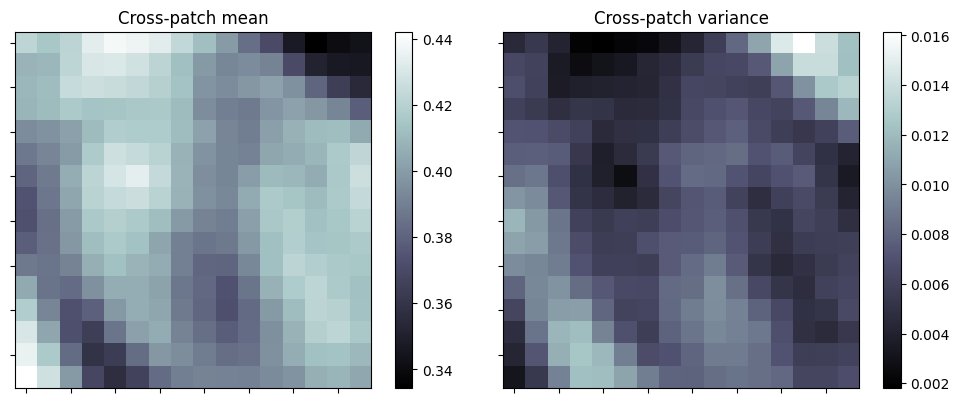

In [45]:
fwd.plot_patch_stats(all_contexts[2])

In [46]:
X = all_contexts[2]
X0 = X.reshape(n_steps, -1)
X0 = X0 - np.mean(X0, axis=0)
X0 = X0 * 64

Cxx0 = np.cov(X0.T)
Cxx = Cxx0 + np.eye(Cxx0.shape[0]) * 1e-4

ll, V = np.linalg.eigh(Cxx)
l12 = 1/np.sqrt(ll)
assert np.allclose(V @ np.diag(ll) @ V.T, Cxx)

Cww = V @ np.diag(l12) @ V.T

(256, 2866)


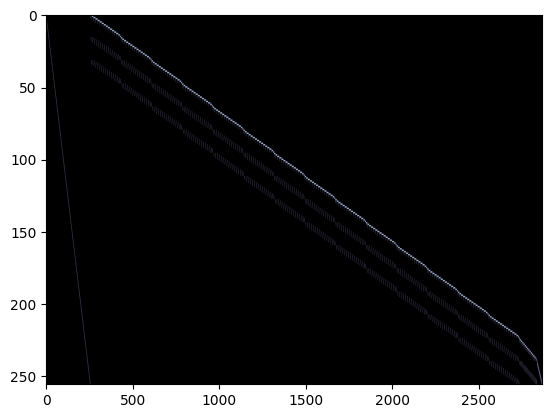

In [61]:
import frame_whitening.simulation_new as sim
n_batch = 2**13
conv_h, conv_w = 3, 3
W = fw.get_conv_frame(patch_h, patch_w, conv_h, conv_w)
print(W.shape)
plt.imshow(W, cmap="bone", aspect="auto")

g_last, g_all, errors, variances = sim.simulate(
                                        cholesky_list=[np.linalg.cholesky(Cxx)], 
                                        W=W, 
                                        batch_size=-1, 
                                        n_batch=n_batch, 
                                        lr_g=1E-2,
                                        g0=None, 
                                        online=False, 
                                        clamp=False,
                                    )

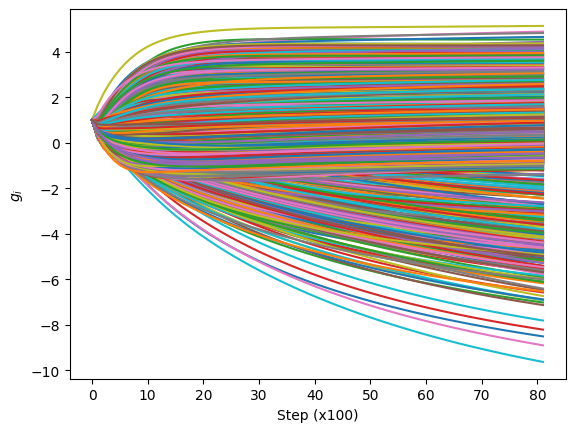

In [62]:
fig, ax = plt.subplots(1, 1)
step_skip = 100
ax.plot(g_all[::step_skip])
ax.set(xlabel=f"Step (x{step_skip})", ylabel=r"$g_i$");

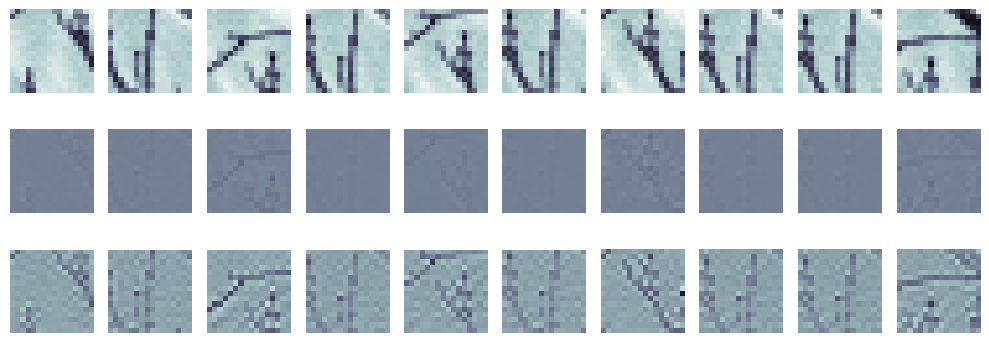

In [63]:
WGW = W @ (g_last[0][:,None] * W.T)
Ixx = np.eye(patch_h * patch_w)
M = np.linalg.inv(Ixx + WGW)
Xw2 = X0 @ M.T

Xw = X0 @ Cww.T

X00 = X0.reshape(n_steps, patch_h, patch_w)
Xw = Xw.reshape(n_steps, patch_h, patch_w)
Xw2 = Xw2.reshape(n_steps, patch_h, patch_w)

fwd.plot_context_samples(np.stack([X00, Xw, Xw2], 0), 10, "Set1", False)

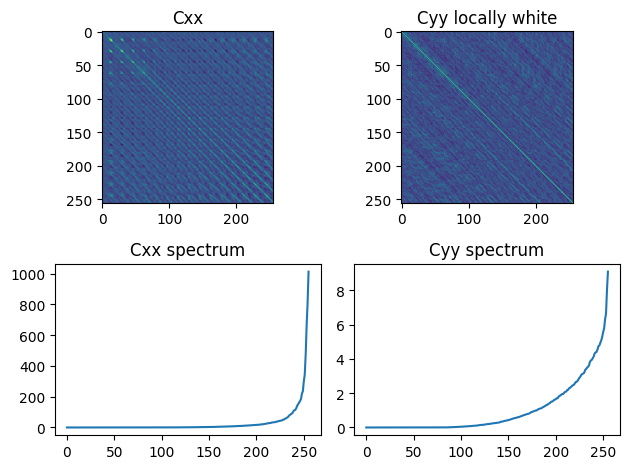

In [64]:
Cw2 = np.cov(Xw2.reshape(n_steps, -1).T)

vv, _ = np.linalg.eigh(Cw2)

fig, ax = plt.subplots(2, 2)
ax[0,0].imshow(Cxx)
ax[0,1].imshow(Cw2)
ax[1,0].plot(np.linalg.eigh(Cxx)[0])
ax[1,1].plot(np.linalg.eigh(Cw2)[0])

ax[0,0].set(title="Cxx")
ax[0,1].set(title="Cyy locally white")

ax[1,0].set(title="Cxx spectrum")
ax[1, 1].set(title="Cyy spectrum")

fig.tight_layout()